## 3.1 누락 데이터 처리

In [10]:
import scipy as sp
import seaborn as sns #통계
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import requests
import re
pd.options.display.max_rows=999
pd.options.display.max_columns=999
%matplotlib inline
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
import missingno as msno


실제 데이터에서는 여러가지 이유로 독립변수가 되는 특징행렬의 데이터 중 일부가 누락(missing)되는 경우가 발생한다. 여기에서는 누락 데이터를 찾고 처리하는 방법을 설명한다.

### 누락 데이터 파싱

누락 데이터 중 문제가 되는 것은 실수형(real number), 정수형(integer), 날짜/시간(datetime) 자료들이다. 문자열의 경우에는 빈 문자열(null string)이나 데이터 없음(NA: not avaiable)을 별도의 범주형 값으로 사용하면 된다. 

누락 데이터가 포함된 데이터 파일을 판다스 데이터프레임으로 처리할 때는 자료형에 주의하여야 한다. 실수형 자료에서는 `NaN`(not a number) 값을 이용하여 누락 데이터를 표시할 수 있지만 정수형에는 `NaN` 값이 없기 때문에 정수값을 실수로 자동 변환한다. 만약 정수형을 유지하고 싶다면 다음 코드와 같이 누락 데이터 표현이 가능한 정수형(nullable integer)인 `Int64Dtype` 자료형을 명시하여야 한다. 날짜 자료형도 마찬가지로 `parse_dates` 인수로 날짜시간형 파싱을 해주어야 `datetime64[ns]` 자료형이 되어 누락 데이터가 `NaT`(not a time) 값으로 표시된다.

In [11]:
from io import StringIO

csv_data = StringIO("""
x1,x2,x3,x4,x5
1,0.1,"1",2019-01-01,A
2,,,2019-01-02,B
3,,"3",2019-01-03,C
,0.4,"4",2019-01-04,A
5,0.5,"5",2019-01-05,B
,,,2019-01-06,C
7,0.7,"7",,A
8,0.8,"8",2019-01-08,B
9,0.9,,2019-01-09,C
""")

df = pd.read_csv(csv_data, dtype={"x1": pd.Int64Dtype()}, parse_dates=[3])

데이터의 자료형은 다음과 같다.

In [12]:
df.dtypes

x1             Int64
x2           float64
x3           float64
x4    datetime64[ns]
x5            object
dtype: object

In [13]:
df.dtypes

x1             Int64
x2           float64
x3           float64
x4    datetime64[ns]
x5            object
dtype: object

누락 데이터가 제대로 표현된 것을 알 수 있다.

In [14]:
df

,x1,x2,x3,x4,x5
0,1,0.1,1.0,2019-01-01,A
1,2,NaN,NaN,2019-01-02,B
2,3,NaN,3.0,2019-01-03,C
3,<NA>,0.4,4.0,2019-01-04,A
4,5,0.5,5.0,2019-01-05,B
5,<NA>,NaN,NaN,2019-01-06,C
6,7,0.7,7.0,NaT,A
7,8,0.8,8.0,2019-01-08,B
8,9,0.9,NaN,2019-01-09,C


In [15]:
df

,x1,x2,x3,x4,x5
0,1,0.1,1.0,2019-01-01,A
1,2,NaN,NaN,2019-01-02,B
2,3,NaN,3.0,2019-01-03,C
3,<NA>,0.4,4.0,2019-01-04,A
4,5,0.5,5.0,2019-01-05,B
5,<NA>,NaN,NaN,2019-01-06,C
6,7,0.7,7.0,NaT,A
7,8,0.8,8.0,2019-01-08,B
8,9,0.9,NaN,2019-01-09,C


### 누락 데이터 포착

데이터프레임의 `isnull` 또는 `isna` 메서드를 사용하면 누락 데이터의 위치를 알 수 있다.

In [16]:
df.isnull()

,x1,x2,x3,x4,x5
0,False,False,False,False,False
1,False,True,True,False,False
2,False,True,False,False,False
3,True,False,False,False,False
4,False,False,False,False,False
5,True,True,True,False,False
6,False,False,False,True,False
7,False,False,False,False,False
8,False,False,True,False,False


In [17]:
df.isnull()

,x1,x2,x3,x4,x5
0,False,False,False,False,False
1,False,True,True,False,False
2,False,True,False,False,False
3,True,False,False,False,False
4,False,False,False,False,False
5,True,True,True,False,False
6,False,False,False,True,False
7,False,False,False,False,False
8,False,False,True,False,False


데이터가 많은 경우에는 일일히 볼 수 없으므로 `sum` 명령으로 누락데이터의 갯수를 셀 수 있다.

In [18]:
df.isnull().sum()

x1    2
x2    3
x3    3
x4    1
x5    0
dtype: int64

In [19]:
df.isnull().sum()

x1    2
x2    3
x3    3
x4    1
x5    0
dtype: int64

`missingno` 패키지를 사용하면 누락데이터에 대한 시각화를 쉽게 할 수 있다. `matrix()`명령은 매트리스 형태로 누락데이터를 시각화하는 명령이다. 누락 데이터는 흰색으로 나타난다. 가장 오른쪽에 있는 것은 스파크라인(spark line)이라고 부르고, 각 행의 데이터 완성도를 표현한다.

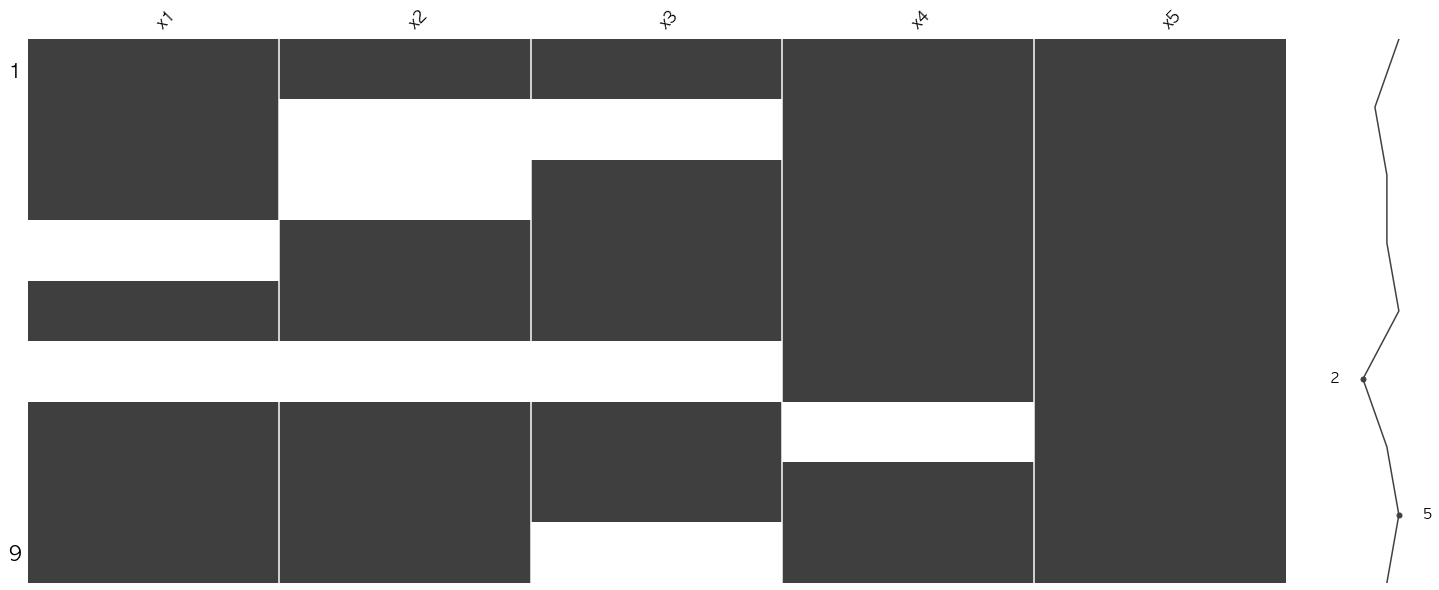

In [20]:
msno.matrix(df)

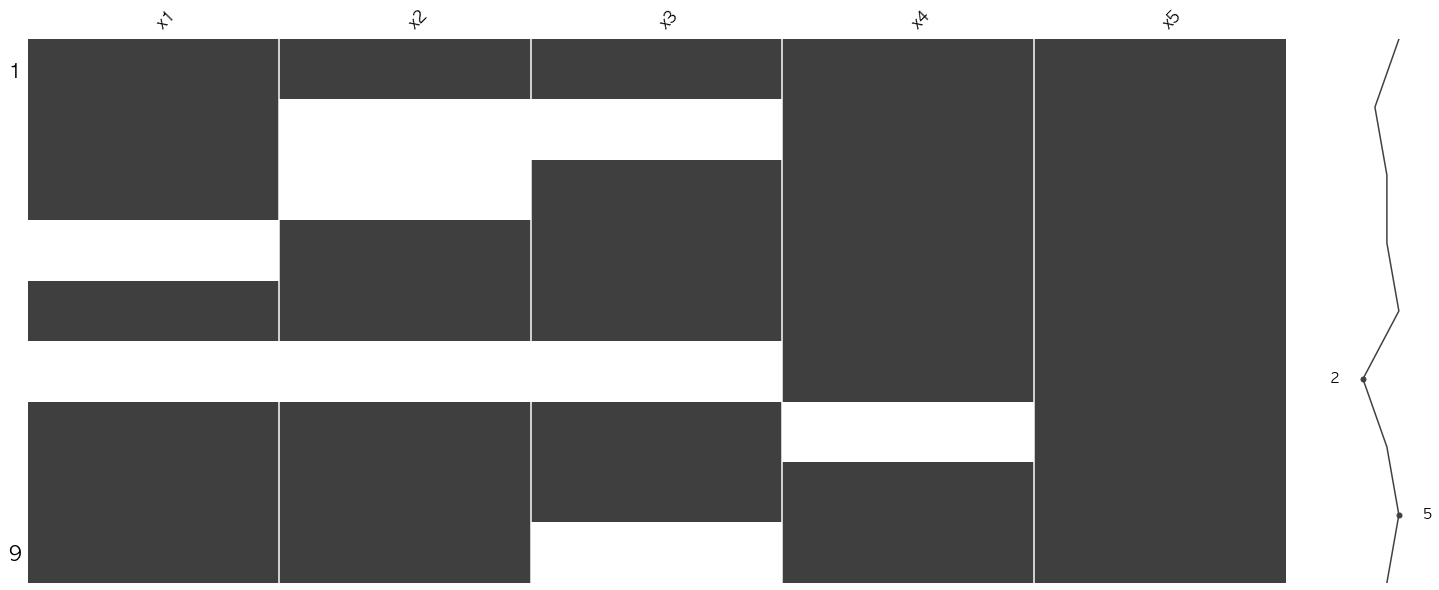

In [21]:
import missingno as msno

msno.matrix(df)
plt.show()

만약 각 열의 누락데이터가 얼마나 존재하는지에 대해서만 시각화 하고 싶다면, `bar()`명령을 사용하면 된다. 

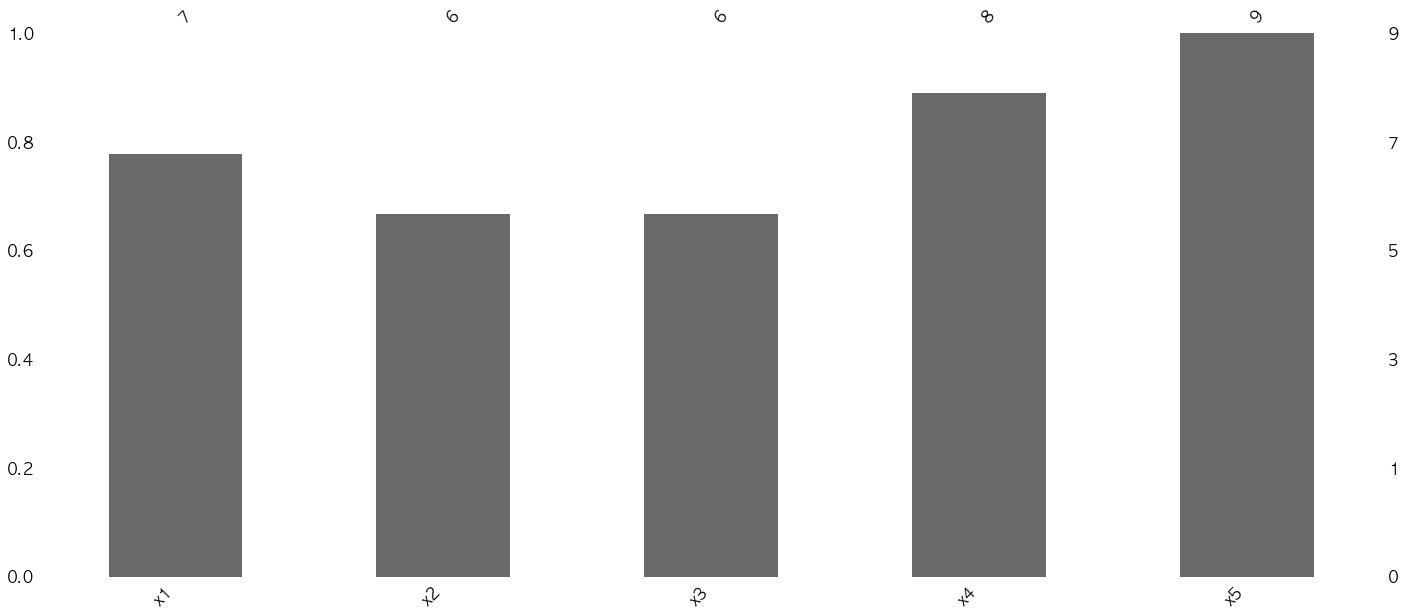

In [22]:
msno.bar(df)

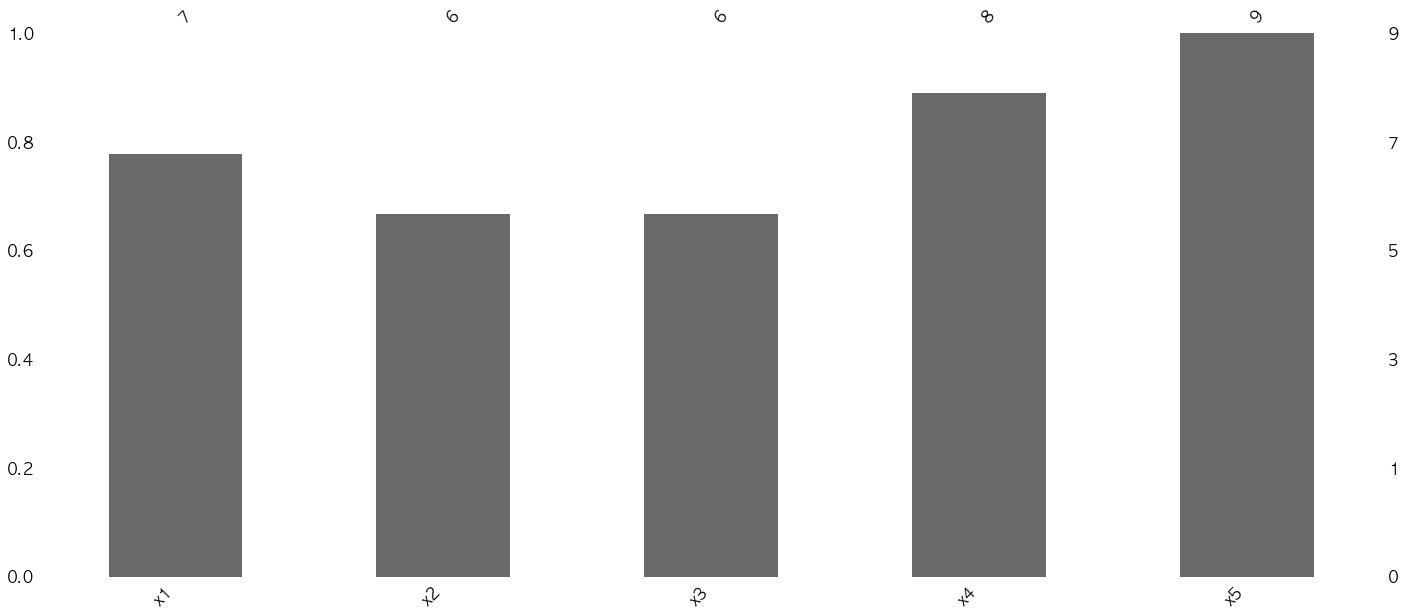

In [23]:
msno.bar(df)
plt.show()

### 누락 데이터 제거

어떤 열(종류)에 누락 데이터가 너무 많으면 그 열의 데이터를 제거해야 한다. 또는 어떤 행(레코드)의 데이터에 누락 데이터가 너무 많은 경우에도 그 행의 데이터를 제거한다. 판다스의 `dropna()`명령을 사용하면 누락 데이터가 존재하는 행이나 열을 지울 수 있다. 

In [24]:
df.dropna()

,x1,x2,x3,x4,x5
0,1,0.1,1.0,2019-01-01,A
4,5,0.5,5.0,2019-01-05,B
7,8,0.8,8.0,2019-01-08,B


In [25]:
df.dropna()

,x1,x2,x3,x4,x5
0,1,0.1,1.0,2019-01-01,A
4,5,0.5,5.0,2019-01-05,B
7,8,0.8,8.0,2019-01-08,B


`thresh` 인수를 사용하면 특정 갯수 이상의 (비누락) 데이터가 있는 행만 남긴다.

In [26]:
df.dropna(thresh=4)

,x1,x2,x3,x4,x5
0,1,0.1,1.0,2019-01-01,A
2,3,NaN,3.0,2019-01-03,C
3,<NA>,0.4,4.0,2019-01-04,A
4,5,0.5,5.0,2019-01-05,B
6,7,0.7,7.0,NaT,A
7,8,0.8,8.0,2019-01-08,B
8,9,0.9,NaN,2019-01-09,C


In [27]:
df.dropna(thresh=4)

,x1,x2,x3,x4,x5
0,1,0.1,1.0,2019-01-01,A
2,3,NaN,3.0,2019-01-03,C
3,<NA>,0.4,4.0,2019-01-04,A
4,5,0.5,5.0,2019-01-05,B
6,7,0.7,7.0,NaT,A
7,8,0.8,8.0,2019-01-08,B
8,9,0.9,NaN,2019-01-09,C


`axis` 인자를 1로 설정하면 누락데이터가 있는 열을 제거한다. 

In [28]:
df.dropna(thresh=7, axis=1)

,x1,x4,x5
0,1,2019-01-01,A
1,2,2019-01-02,B
2,3,2019-01-03,C
3,<NA>,2019-01-04,A
4,5,2019-01-05,B
5,<NA>,2019-01-06,C
6,7,NaT,A
7,8,2019-01-08,B
8,9,2019-01-09,C


In [29]:
df.dropna(thresh=7, axis=1)

,x1,x4,x5
0,1,2019-01-01,A
1,2,2019-01-02,B
2,3,2019-01-03,C
3,<NA>,2019-01-04,A
4,5,2019-01-05,B
5,<NA>,2019-01-06,C
6,7,NaT,A
7,8,2019-01-08,B
8,9,2019-01-09,C


### 누락 데이터 대체

누락 데이터를 처리하는 또다른 방법은 다른 독립변수 데이터로부터 누락된 데이터를 추정하여 대체(imputation)하는 것이다.

seaborn 패키지에서 제공하는 타이타닉 생존자 데이터를 예로 들어 누락 데이터 대체 방법을 설명한다. 

In [30]:
df = sns.load_dataset("titanic")
df.tail()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
886,0,2,male,27.0,0,0,13.00,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.00,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.45,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.00,C,First,man,True,C,Cherbourg,yes,True
890,0,3,male,32.0,0,0,7.75,Q,Third,man,True,NaN,Queenstown,no,True


In [31]:
df = sns.load_dataset("titanic")

타이타닉 생존자 데이터의 각 열이 의미하는 바는 다음과 같다. 

- survived : 생존 여부 
- pclass : 승객의 클래스 
- sex : 성별 
- sibsp : 형제 혹은 자매의 수 
- parch : 부모 혹은 자녀의 수 
- fare : 탑승 요금 
- embarked : 출발지의 고유 이니셜 
- class : 선실의 클래스
- who : male, female을 man, woman으로 표기 
- adult_male : 성인 남성 인지 아닌지 여부 
- deck : 선실 고유 번호의 가장 앞자리 알파벳(A ~ G)
- embark_town : 출발지 
- alive : 생존 여부 데이터를 yes 혹은 no로 표기 
- alone : 가족이 없는 경우 True

타이타닉 데이터의 age 열과 deck 열에는 다음과 같이 누락 데이터가 존재 한다. deck 열은 누락 데이터의 비중이 절반이 넘기 때문에 전체를 제거하기로 한다.

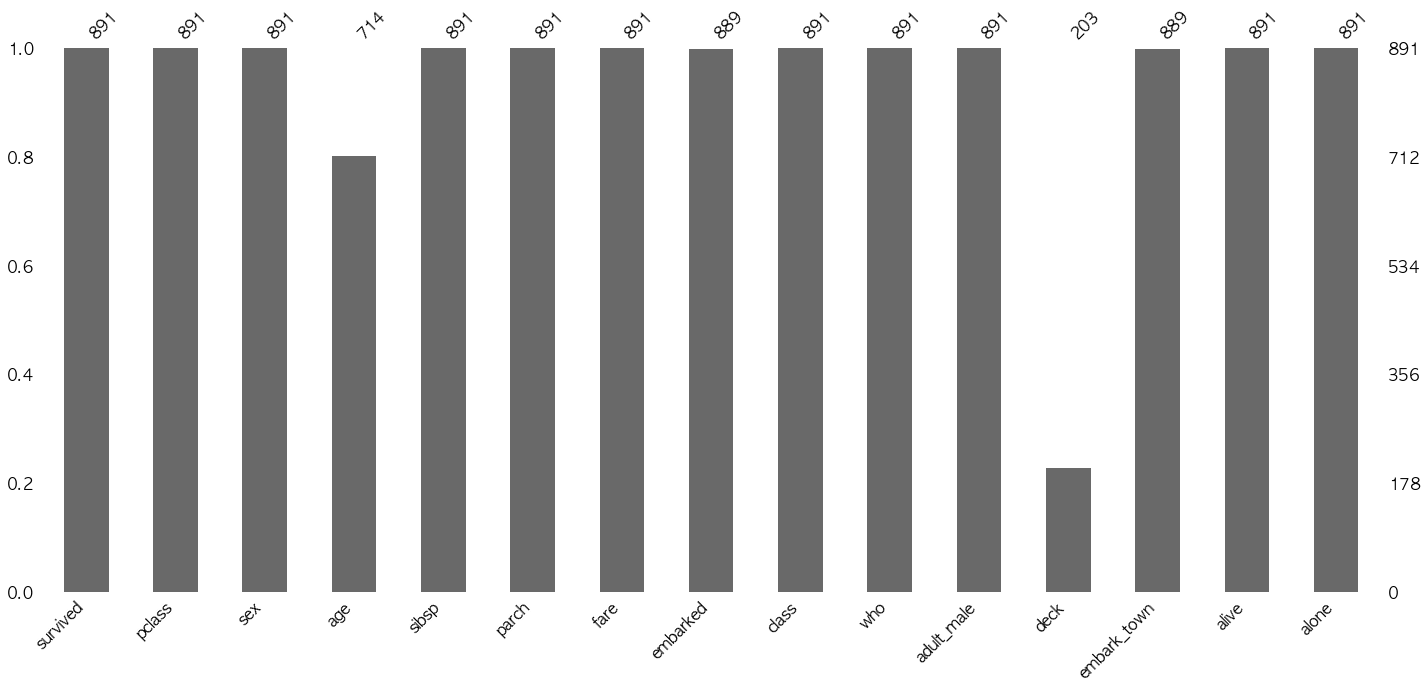

In [32]:
msno.bar(df)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

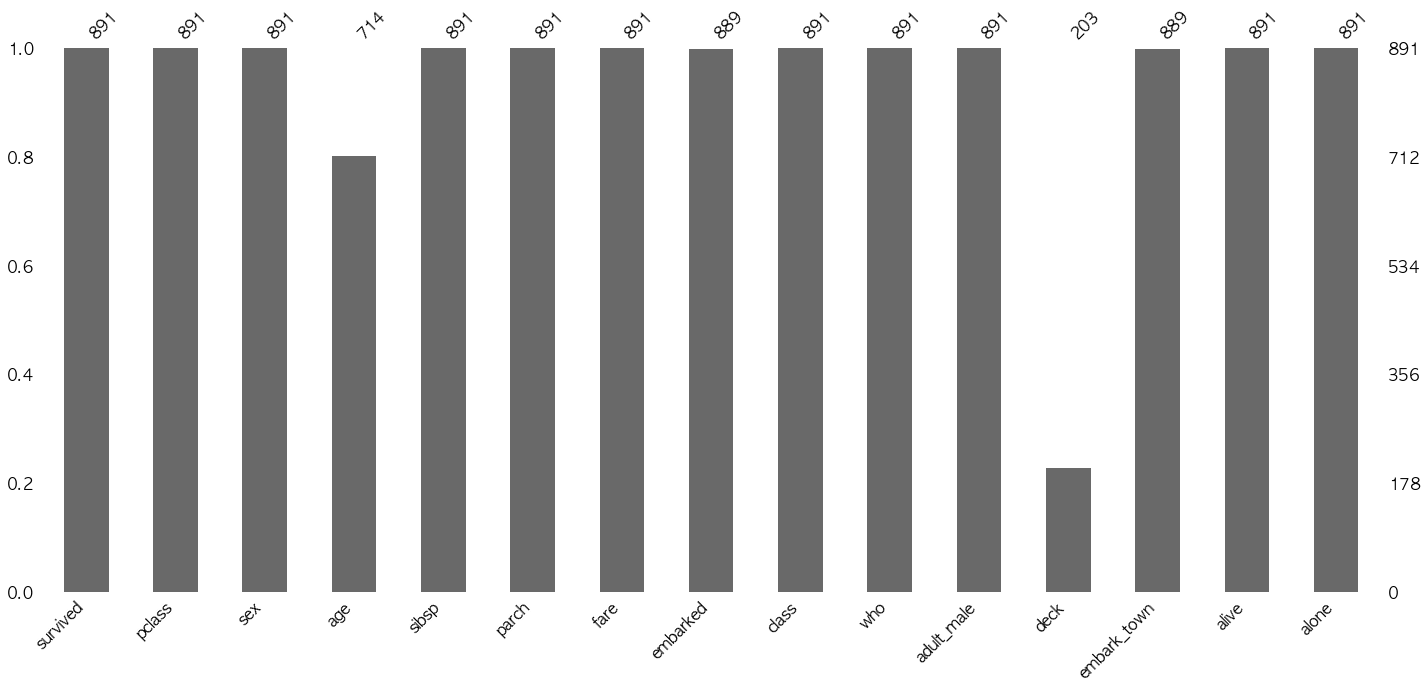

In [33]:
msno.bar(df)
plt.show

age의 분포를 시각화 해본 결과는 다음과 같다.

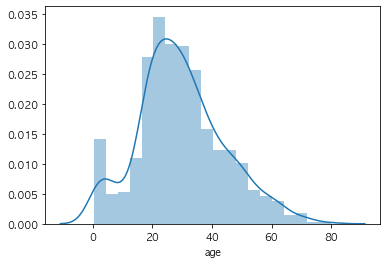

In [34]:
sns.distplot(df.age.dropna())

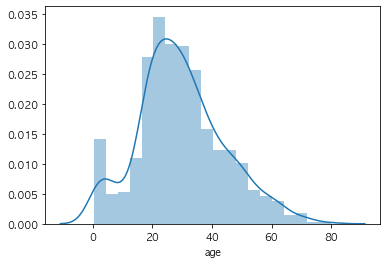

In [35]:
sns.distplot(df.age.dropna())

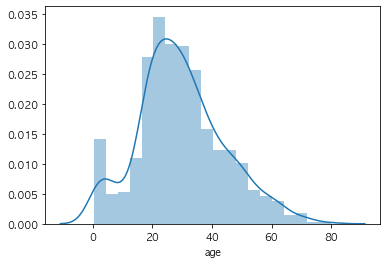

In [36]:
sns.distplot(df.age.dropna())
plt.show()

scikit-learn 패키지의 `SimpleImputer` 클래스를 사용하면 누락된 정보를 채울 수 있다. 

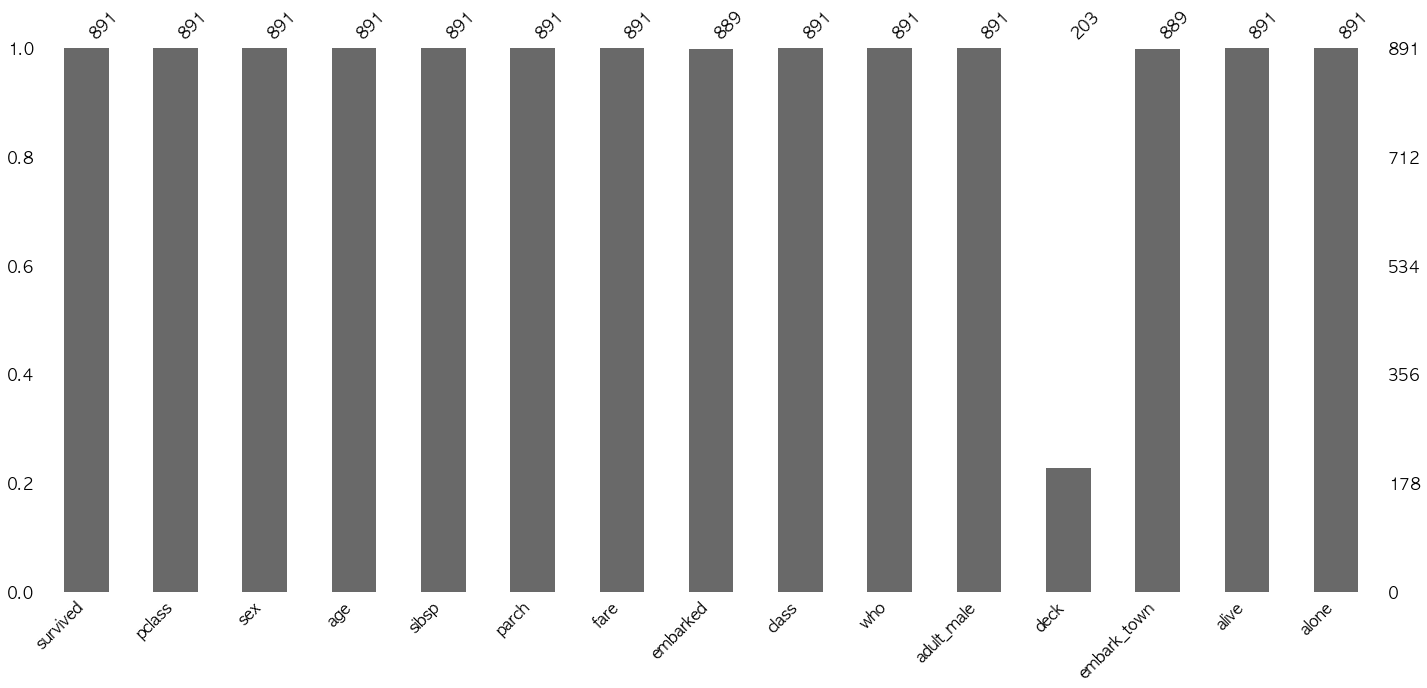

In [37]:
imputer = SimpleImputer(strategy="most_frequent")#mean, median 
df_copy1 = df.copy()
df_copy1["age"]= imputer.fit_transform(df.age.values.reshape(-1,1))

msno.bar(df_copy1)
plt.show()

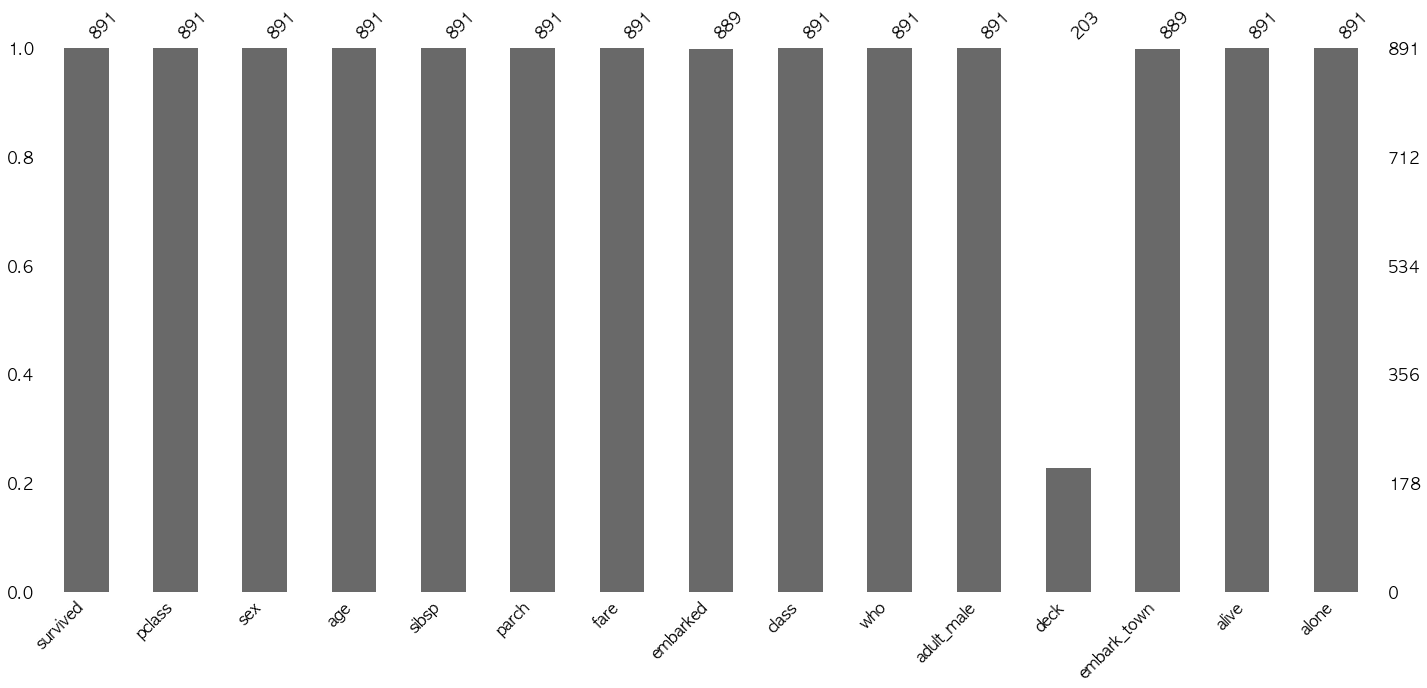

In [38]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")
df_copy1 = df.copy()
df_copy1["age"] = imputer.fit_transform(df.age.values.reshape(-1,1))

msno.bar(df_copy1)
plt.show()

In [39]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
df_copy1 = df.copy()
df_copy1["age"] = imputer.fit_transform(df.age.values.reshape(-1,1))

df_copy1
msno.bar(df_copy1)
plt.show()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.00,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.00,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.00,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.00,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.00,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,28.00,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.00,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.00,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.00,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.00,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


다른 데이터를 이용해서 더 그럴듯한 대체 방법을 사용할 수도 있다. 예를 들어 클래스(pclass)별로 평균 나이가 다르다는 점을 이용하여

In [40]:
df.groupby(df.pclass).age.median()

pclass
1    37.0
2    29.0
3    24.0
Name: age, dtype: float64

In [41]:
df.groupby(df.pclass).age.median()

pclass
1    37.0
2    29.0
3    24.0
Name: age, dtype: float64

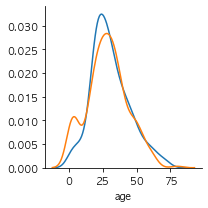

In [42]:
g=sns.FacetGrid(df, hue="survived")
g.map(sns.kdeplot,"age")

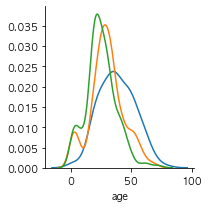

In [43]:
g=sns.FacetGrid(df, hue="pclass")
g.map(sns.kdeplot,"age")

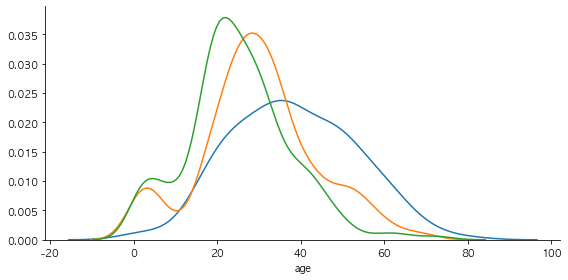

In [44]:
g=sns.FacetGrid(df, hue="pclass", height=4, aspect=2)
g.map(sns.kdeplot,"age")
plt.show()

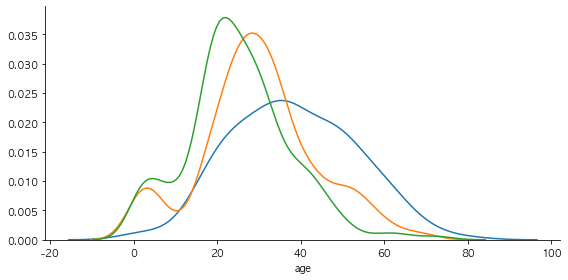

In [45]:
g = sns.FacetGrid(df, hue="pclass", height=4, aspect=2)
g.map(sns.kdeplot, "age")
plt.show()

클래스마다 별도로 대체값을 찾을 수도 있다.

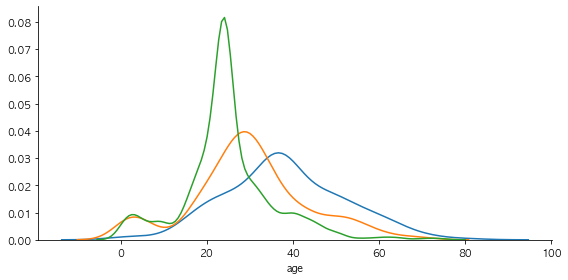

In [46]:
df_copy2 = df.copy()
df_copy2["age"] = df.groupby(df.pclass).age.transform(lambda x: x.fillna(x.median()))

g = sns.FacetGrid(df_copy2, hue="pclass", height=4, aspect=2)
g.map(sns.kdeplot, "age")
plt.show()